In [1]:
from simulator import Simulator
import matplotlib.pyplot as plt

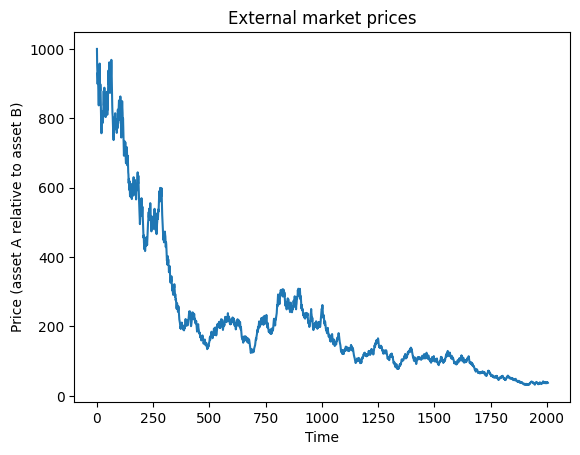

In [2]:
simulator = Simulator()

n = 2004 # ~ 33 minutes
min_vol = 1 # (%)
max_vol = 5 # (%)

external_prices = simulator.generate_price_data(n=2005, min_vol=min_vol/100, max_vol=max_vol/100)

plt.plot(external_prices)
plt.xlabel('Time')
plt.ylabel('Price (asset A relative to asset B)')
plt.title('External market prices')
plt.show()

Arbitrageurs are more profitable on XRPL 60% of the time


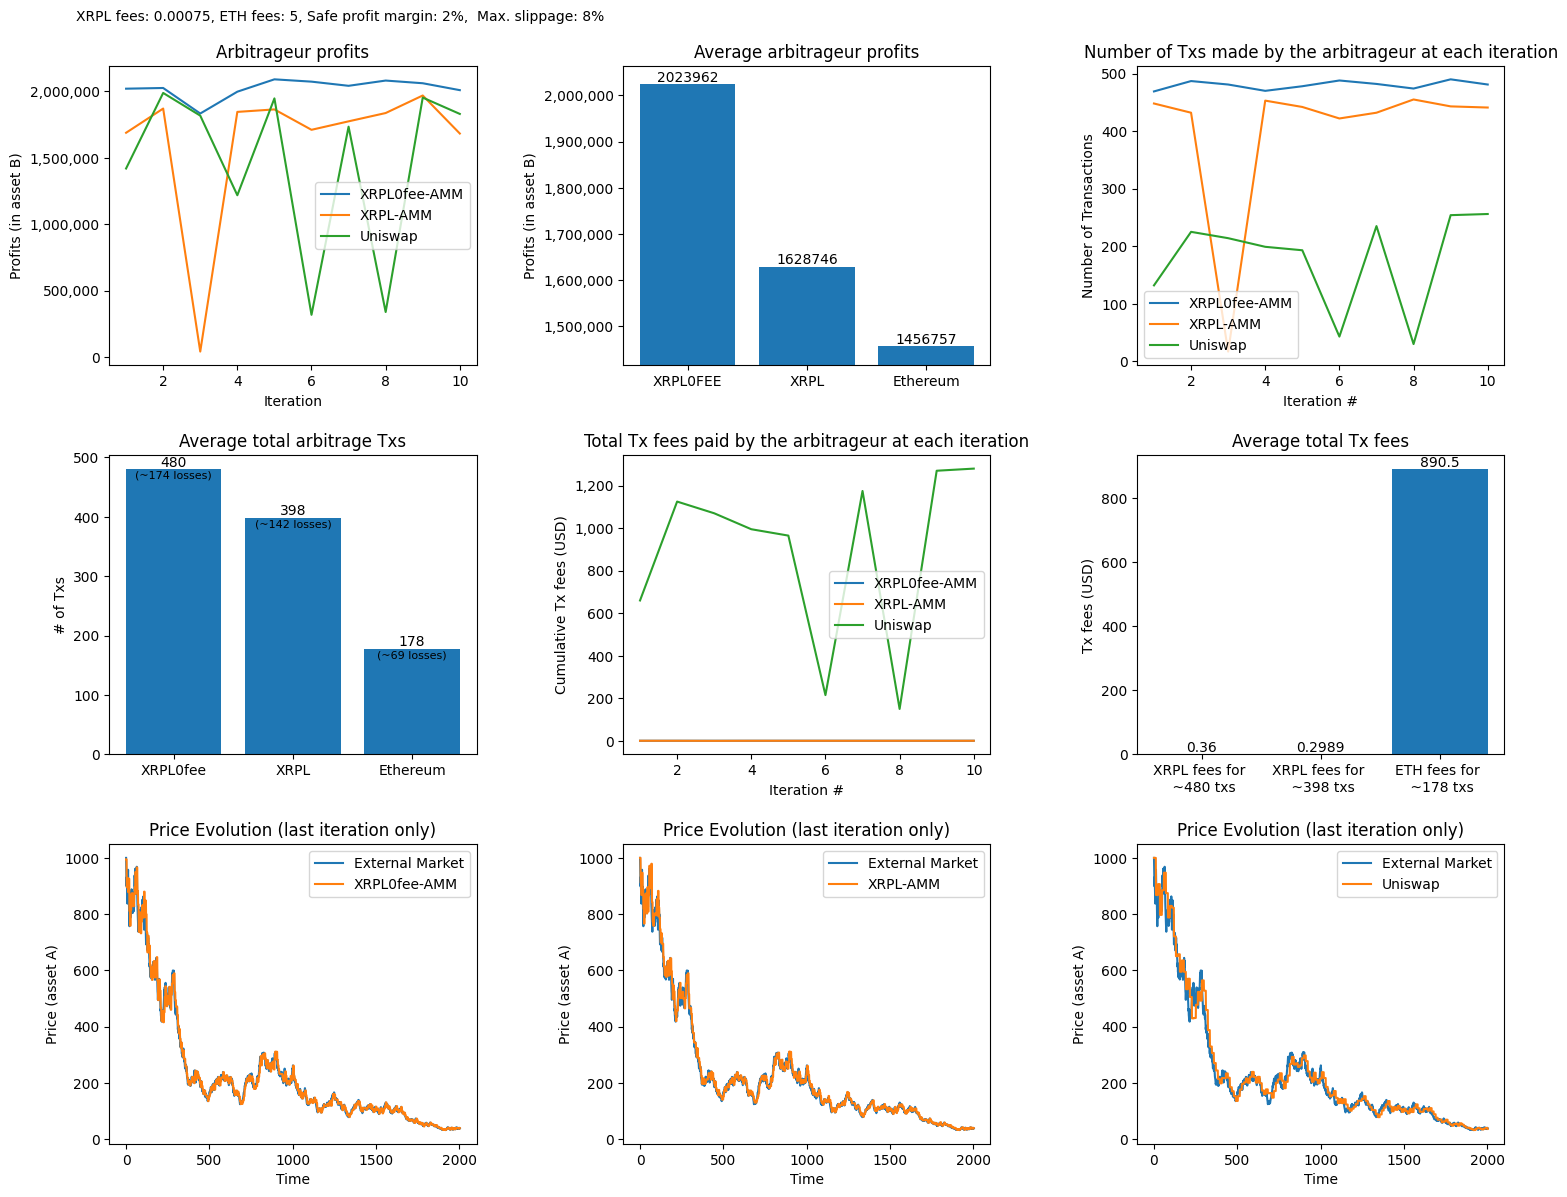

In [3]:
xrpl_block_conf = 4
eth_block_conf = 12
xrpl_fees = 0.00075
eth_fees = 5
safe_profit_margin = 2 # (%)
max_slippage = 8 # (%)
iterations = 10

sim = simulator.run_simulaton(external_prices, xrpl_block_conf, eth_block_conf, xrpl_fees, eth_fees, safe_profit_margin/100, max_slippage/100, iterations)
simulator.display_results(sim, external_prices, iterations, xrpl_fees, eth_fees, safe_profit_margin, max_slippage)